# Lecture 7.4: The Generalized Linear Model

## Outline  

* [Logistic Regression Review](#Logistic-Regression-Review)
* [Generalized Linear Model](#GLM)
* [Bernoulli (binomial) Distribution](#Bernoulli-Distribution)
* [Interpreting Results](#Interpreting-Results)

# Logistic Regression Review

### Example

Emails are collected from a single email account, and we want to develop a basic spam filter using these data. The response variable, spam, has been encoded to take value 0 when a message is not spam and 1 when it is spam. Our task is to build an appropriate model that classifies messages as spam or not spam using email characteristics coded as predictor variables.

In [1]:
%pylab inline

import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import yaml

from sqlalchemy import create_engine
from statsmodels.genmod.families import family

pg_creds = yaml.load(open('../../pg_creds.yaml'))['student']

engine = create_engine('postgresql://{user}:{password}@{host}:{port}/{dbname}'.format(**pg_creds))

Populating the interactive namespace from numpy and matplotlib


In [2]:
emails = pd.read_sql_table('email', engine, index_col='msg_id')
emails.head()

,spam,to_multiple,from,cc,sent_email,time,image,attach,dollar,winner,...,viagra,password,num_char,line_breaks,format,re_subj,exclaim_subj,urgent_subj,exclaim_mess,number
msg_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,12/31/11 22:16,0,0,0,no,...,0,0,11.370,202,1,0,0,0,0,big
1,0,0,1,0,0,12/31/11 23:03,0,0,0,no,...,0,0,10.504,202,1,0,0,0,1,small
2,0,0,1,0,0,1/1/12 8:00,0,0,4,no,...,0,0,7.773,192,1,0,0,0,6,small
3,0,0,1,0,0,1/1/12 1:09,0,0,0,no,...,0,0,13.256,255,1,0,0,0,48,small
4,0,0,1,0,0,1/1/12 2:00,0,0,0,no,...,0,2,1.231,29,0,0,0,0,1,none


We will use the following variables to build the model:  

* `spam`: Specifies whether the message was spam  

* `num_char`: The number of characters in the email  

* `line_breaks`: The number of line breaks in the email (not including text wrapping)

* `to_multiple`: An indicator variable for if more than one person was listed in the To field of the email.  

* `cc`: An indicator for if someone was CCed on the email.  

* `attach`: An indicator for if there was an attachment, such as a document or image.  

* `dollar`: An indicator for if the word "dollar" or dollar symbol (\$) appeared in the email.  

* `re_subj`: Indicates whether "Re:" was included at the start of the email subject.

First, let's try to build a simple linear regression model to classify the emails based on the number of characters in the email - `num_char`.

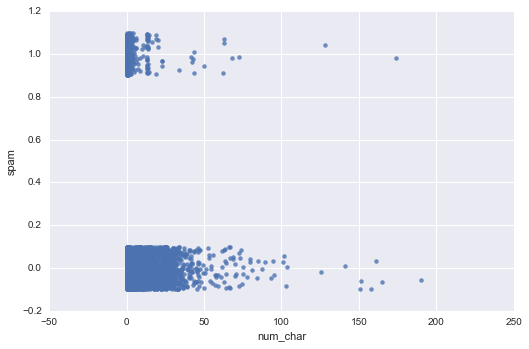

In [3]:
sns.lmplot('num_char', 'spam', emails, aspect=1.5, y_jitter=.1, fit_reg=False);

<!--
We use logistic regression to convert probabilities...
========================================================
![probabilities](images/logistic_regression1.png)

...into class labels!
========================================================
![class labels](images/logistic_regression2.png)

Probabilities are “snapped” to class labels  
(e.g. by threshholding at 50%).

Example problems: Logistic Regression
========================================================
Credit Transactions: Fraudulent? (Yes, No)

Gender of a user: (boy, girl)

Do I have $x$ disease: (yes, no)

Will a student get the question right on the test? (yes, no)
-->

Logistic vs Linear Regression
========================================================
Both of these models work similarly. In fact, we can think of logistic regression as an extension of linear regression.

There are a couple important differences, however

- Difference 1: Outcome Variables
- Difference 2: Error Terms

### The Linear Regression Model

In [4]:
model1 = smf.ols('spam ~ num_char', data = emails).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   spam   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     53.07
Date:                Fri, 14 Oct 2016   Prob (F-statistic):           3.87e-13
Time:                        14:00:34   Log-Likelihood:                -700.71
No. Observations:                3921   AIC:                             1405.
Df Residuals:                    3919   BIC:                             1418.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1182      0.006     20.649      0.000       0.107       0.129
num_char      -0.0023      0.000     -7.285      0.000      -0.003      -0.002
==============================================================================
Omnibus:                     2106.012   Durbin-Watson:                   0.129
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10125.796
Skew:                           2.742   Prob(JB):                         0.00
Kurtosis:                       8.649   Cond. No.                         22.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

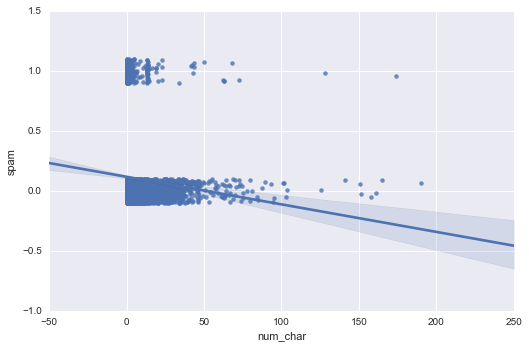

In [5]:
sns.lmplot('num_char', 'spam', emails, aspect=1.5, y_jitter=.1);

### The Logistic Regression Model

In [6]:
logit_model1 = smf.logit('spam ~ num_char', data = emails).fit()
logit_model1.summary()

Optimization terminated successfully.
         Current function value: 0.299210
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   spam   No. Observations:                 3921
Model:                          Logit   Df Residuals:                     3919
Method:                           MLE   Df Model:                            1
Date:                Fri, 14 Oct 2016   Pseudo R-squ.:                 0.03725
Time:                        14:00:40   Log-Likelihood:                -1173.2
converged:                       True   LL-Null:                       -1218.6
                                        LLR p-value:                 1.607e-21
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7987      0.072    -25.135      0.000      -1.939      -1.658
num_char      -0.0621      0.008     -7.746      0.000      -0.078      -0.046
==============================================================================
"""

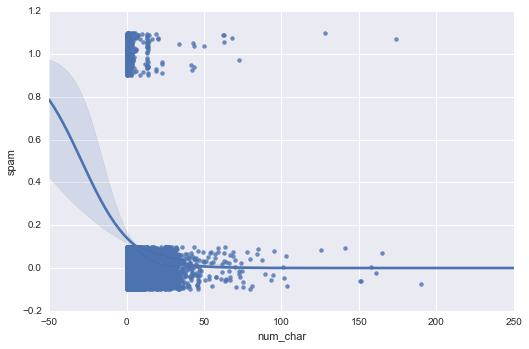

In [7]:
sns.lmplot('num_char', 'spam', emails, aspect=1.5, y_jitter=.1, logistic=True);

<!--
The Python output states that  

$$ P(spam = 1) = \frac{exp(-1.7987 - 0.0621 \times num\_char)}{1 + exp(-1.7987 - 0.0621 \times num\_char)} $$
-->

# Outcome Variables

The key variable in any regression problem is the **conditional mean** of the outcome variable y given the value of the covariate x:

_Conditional mean_: $E(y|x)$

In linear regression, we assume that this conditional mean is a linear function taking values in $(-\infty, +\infty)$:

$$ E(y|x) = \alpha + \beta x $$

## Why we shouldn't use linear regression for classification problems

Bounds can be greater than 0 and 1

Sometimes extra data can really throw off our thresholds

Impossible to scale/predict when data throws off the regression

## Outcome Variables

In logistic regression, we’ve seen that the _conditional mean of the outcome variable takes values only in the unit interval [0, 1]_.

0 = negative class (false)

1 = positive class (true)

The first step in extending linear regression to logistic regression is to map the outcome variable $E(y|x)$ into the unit interval.

## How do we do this?

By using a transformation called the **logistic function**:
$$ E(y \mid x) = \pi(x) = \frac{e^{\alpha + \beta x}}{1 + e^{\alpha + \beta x}} $$

We've already seen what this looks like:  
![probabilities](images/logistic_regression1.png)

For any value of x, y is in the interval [0, 1]  
This is a nonlinear transformation!

## The Logistic Function

The **logit function** is an important transformation of the logistic function. Notice that it returns the linear model!  
$$ g(x) = ln\left(\frac{\pi(x)}{1-\pi(x)}\right) = \alpha + \beta x $$

Here, $\pi(x)$ ($pi$ of $x$) is the probability of $x$ occuring

(The logit function is also called the **log-odds function**)

## Outcome Variables - Review

The expected outcome for a logistic regression is anywhere in the range of 0 and 1.

A conditional mean just represents the average expected value from a prediction

The logistic formula transformation is what allows us to scale our regression results

# Error Terms

The second difference between linear regression and the logistic regression model is in the error term.

One of the key assumptions of linear regression is that the error terms follow independent Gaussian distributions with zero mean and constant variance:  
$$ \epsilon \sim N(0, \sigma^2) $$

## OLS vs. MLE

Consider the following:  

| Case | Model 1 | Model 2 | Observed Value |
|:----:|:-------:|:-------:|:----:|
|   1   |    0.8 |     1.0 | 1 |
|   2   |    0.1 |     0.0 | 1 |
|   3   |    0.9 |     1.0 | 1 |
|   4   |    0.5 |     0.0 | 0 |
| Sum Sq. Resid | 1.11 | 1.00 |

According to OLS, Model 2 is superior than model _even though Model 2 says it's **impossible** to have an outcome of 1 in case 2_.

## Logistic Regression

In logistic regression, the outcome variable can take only two values: 0 or 1.

It’s easy to show from this that instead of following a Gaussian distribution, the error term in logistic regression follows a Bernoulli distribution:  
$$ \epsilon \sim B(\pi, \pi(1-\pi)) $$

This is the same distribution followed by a coin toss.  
Think about why this makes sense!

## OLS vs. MLE

This is no good. If our model says an event is _impossible_ but it happens anyway, _that is not a good model_. 

Remember: we are dealing with probabilities. We should _treat_ them like probabilities.

Model 1: $P(1,1,1,0) = 0.8 \times 0.1 \times 0.9 \times (1-0.5) = 0.036$

Model 2: $P(1,1,1,0) = 1 \times 0 \times 1 \times (1 - 0) = 0$

**Conclusion:** Model 1 is better.

This is called the Maximum Liklihood Estimate or MLE

# GLM

These two key differences

( 
+ response variable 
+ solver

)

define the logistic regression model, and they also lead us to a kind of unification of regression techniques called **generalized linear models**.

Briefly, GLMs generalize the distribution of the error term, and allow the conditional mean of the response variable to be related to the linear model by a **link function**.

In the present case, the error term follows a Bernoulli distribution, and the logit is the link function that connects us to the linear predictor.

$$ g(x) = ln\left(\frac{\pi(x)}{1-\pi(x)}\right) = \alpha + \beta x $$

Since the Bernoulli distribution and the logit function share a common parameter $\pi$, we say that the logit is the **canonical link function** for the Bernoulli distribution.

## Linear Regression using OLS in `statsmodels`

In [8]:
model1 = smf.ols('spam ~ num_char', data = emails).fit()
model1.params

Intercept    0.118214
num_char    -0.002299
dtype: float64

## Linear Regression using GLM in `statsmodels`

In [9]:
glm_norm = smf.glm('spam ~ num_char', data = emails).fit()
glm_norm.params

Intercept    0.118214
num_char    -0.002299
dtype: float64

## Linear Regression using GLM (with `family` specified)

In [10]:
glm_norm = smf.glm('spam ~ num_char', data = emails, family=family.Gaussian()).fit()
glm_norm.params

Intercept    0.118214
num_char    -0.002299
dtype: float64

## Logistic Regression using Logit

In [11]:
smf.logit('spam ~ num_char', data = emails).fit().params

Optimization terminated successfully.
         Current function value: 0.299210
         Iterations 8


Intercept   -1.798738
num_char    -0.062071
dtype: float64

## Logistic Regression using GLM

In [12]:
glm_binom = smf.glm('spam ~ num_char', data = emails, family=family.Binomial()).fit()
glm_binom.params

Intercept   -1.798738
num_char    -0.062071
dtype: float64

# Bernoulli Distribution

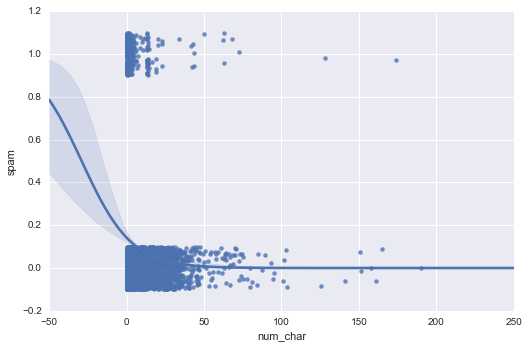

In [13]:
sns.lmplot('num_char', 'spam', emails, aspect=1.5, y_jitter=.1, logistic=True);

This utilizes logit for our link function.

Error terms - Review
========================================================
The Gaussian discribution represents the typical distribution we'd see in a linear regression

The Bernoulli represents the typical distribution we'd see in a logistic regression

Understanding these two distributions helps us better understand what should be expected in our outcomes

---

# GLM for Poisson Data

### GLM for Counts

Situation: The outcome variable $Y$ is a count

GLM for counts have as it’s random component the **Poisson Distribution**

1. Number of cargo ships damaged by waves (classic example given by McCullagh & Nelder, 1989)
2. Number of deaths due to AIDS in Australia per quarter
3. Daily homicide counts in California

### Poisson Rates

In some cases, the counts are affected by the amount of “exposure”.

For example, the number of homicides may be affected by

1. The underlying population size
2. The local gun laws
3. The size of the police force

When this occurs, we may want to take into account the “denominator” and form a rate such as

$$\frac{Y}{t} = rate$$

where $t$ represents a quantification of exposure.

We will also look that this defined as
$$Y = rate \times t$$

### Components of the GLM

The components of a GLM for a count response are

1. Random Component: Poisson distribution and model the expected value of $Y$, denoted by $E(Y) = \mu$.
2. Systematic component: For now we will look at just one explanatory variable $x$
3. Link: We could use
    1. **Identity Link** which would give us $$\mu = \alpha + \beta x$$ But, just as for binomial data, the model can yield $\mu < 0$ (Note $\mu \geq 0$)
    2. **Log Link** (most common and the canonical link) $$log(\mu) = \alpha + \beta x$$

### Poisson Loglinear Model

Our model is
$$log(\mu) = \alpha + \beta x$$

Since the log of the expected value of $Y$ is a linear function of explanatory variable(s), and
the expected value of $Y$ is a multiplicative function of $x$:

$$\mu = e^{\alpha+\beta x}\\
\mu = e^\alpha e^{\beta x}$$
What does this mean for $\mu$? How do we interpret $\beta$?

Consider 2 values of $x$, say ($x_1$ & $x_2$) such that the difference between them equals 1. For
example, $x_1 = 10$ and $x_2 = 11$.

Denote, $\mu_1 = E(Y | x = 10)$. Then
$$\mu_1 = e^\alpha e^{\beta 10}$$
and the expected value when $x = 11$ is
$$\mu_2 = e^\alpha e^{\beta 11}\\
= e^\alpha e^{\beta 10} e^\beta\\
= \mu_1 e^\beta$$
Thus, a 1-unit change in $x$ has a multiplicative effect on the mean of $Y$.

1. If $\beta = 0$, then $e^0 = 1$ and $\mu_2$ is the same as $\mu_1$. That is, $\mu = E(Y)$ is not related to $x$.
2. if $\beta > 0$, then $e^\beta > 1$ and $\mu_2$ is $e^\beta$ times **larger** than $\mu_1$.
3. if $\beta < 0$, then $e^\beta < 1$ and $\mu_2$ is $e^\beta$ times **smaller** than $\mu_1$.

### Example 

<!--small>Adapted from [stat.umn.edu/geyer/5931/mle/seeds.pdf](http://www.stat.umn.edu/geyer/5931/mle/seeds.pdf)</small-->

As part of a research program to assess the evolutionary consequences of extreme
population fragmentation, Stuart Wagenius has conducted a field experiment to 
study seedling recruitment in *Echinacea angustifolia*
(purple coneflower).  The 
experiment was designed to test the effect of different vegetation types and 
burn treatments on recruitment.  Interactions between these factors were also
of interest.

Approximately 100 seeds were sown into each plot.  In order to establish the 
viability of each seed lot, germination trials were conducted in the lab on
randomly chosen lots of a known number of seeds (also around 100).  It was 
of interest to take into account the results of the germination trials in 
the analysis of the data from the field experiment.

The experiment was conducted for three years, with new lots of seeds sown 
into a separate set of plots in the fall of each year and seedling 
establishment monitored in the spring.  

The data for the year 2003 can be read into `python` and inspected by

In [14]:
mydata = pd.read_table("https://s3-us-west-2.amazonaws.com/dsci/6002/data/seeds.txt", delim_whitespace=True)
mydata.head()

,vegtype,burn01,burn02,burn03,totalseeds,seedlings
1,oldfieldcool,yes,no,no,100,5
2,oldfieldcool,yes,no,no,100,3
3,oldfieldcool,yes,no,no,100,4
4,oldfieldcool,no,no,no,100,0
5,oldfieldcool,no,no,no,100,3


from which we see there are six variables in the data set
`vegtype`, `burn01`, `burn02`, `burn03`,
`totalseeds`, and `seedlings`.

Working backwards from the end, `seedlings` is the number of seedlings
that sprouted.  This is the response and is assumed to be
$\text{Poisson}(n \lambda)$, where $n$ is the number of seeds sown,
the variable `totalseeds` in the data set, and $\lambda$ is some
function of the other covariates (`vegtype` and the three `burn`
variables).

The variable `vegtype` indicates the type of field.  The `oldfield`
part of a value (in both `oldfieldcool` and `oldfieldwarm`)
indicates that the field was once used for agriculture.  The
`warm` part of a value (in both `oldfieldwarm` and `plantwarm`)
indicates warm weather grasses were growing in the field and
the `cool` part of a value indicates cool weather grasses.
The value `yes` for the variables `burn01`, `burn02`,
and `burn03` indicates that a field was burned in 2001, 2002, or 2003,
respectively.  Owing to a mistake in the experimental design `burn03`
is completely confounded with `vegtype` and hence has been omitted from
the analysis (this isn't right, but it is not clear what else to do).

In [15]:
out = smf.glm('seedlings ~ vegtype + burn01 == "no" + burn02 == "no"', 
              data=mydata, 
              offset=log(mydata.totalseeds), 
              family=family.Poisson()).fit()
out.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              seedlings   No. Observations:                  177
Model:                            GLM   Df Residuals:                      170
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -410.11
Date:                Fri, 14 Oct 2016   Deviance:                       501.15
Time:                        14:22:22   Pearson chi2:                     563.
No. Iterations:                     7                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.6353      0.058    -28.229      0.000      -1.749      -1.522
vegtype[T.oldfieldcool]    -1.1184      0.193     -5.805      0.000      -1.496      -0.741
vegtype[T.oldfieldwarm]    -0.9849      0.224     -4.390      0.000      -1.425      -0.545
vegtype[T.plantcool]       -2.5315      0.274     -9.225      0.000      -3.069      -1.994
vegtype[T.plantwarm]       -1.7280      0.229     -7.551      0.000      -2.176      -1.279
burn01 == "no"[T.True]     -0.6843      0.153     -4.476      0.000      -0.984      -0.385
burn02 == "no"[T.True]     -0.7204      0.156     -4.611      0.000      -1.027      -0.414
===========================================================================================
"""

The way this works is that the mean value parameter is n. The link function
we are using is “log” (the default for the poisson family), which makes the linear
predictor the same as the canonical parameter
$$\eta = \log(n) + \log(\lambda)$$
thus we see that $\log(n)$ is just a *known* constant additive term in the linear
predictor. The way `statsmodels` handles such a term in the linear predictor that does
not contain an unknown parameter to fit is as an “offset”. Since the variable
$n$ in the math formula is the variable `totalseeds` in python, the “offset” is
`log(totalseeds)`.

Thus the model being fit is that the linear predictor value of the $i$-th case is
$$\eta_i = \log(n_i) + \sum_{j=1}^k d_{ij}\beta_j$$
where the $\beta_j$ are the regression coefficients and $d_{ij}$ the value of the $j$-th dummy
variable for the $i$-th case. You don’t create the dummy variables. `statsmodels` does that
for itself.

From https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function:
<table class="wikitable" style="background:white;">
<caption>Common distributions with typical uses and canonical link functions</caption>
<tbody><tr>
<th>Distribution</th>
<th>Support of distribution</th>
<th>Typical uses</th>
<th>Link name</th>
<th>Link function</th>
<th>Mean function</th>
</tr>
<tr>
<td><a href="/wiki/Normal_distribution" title="Normal distribution">Normal</a></td>
<td>real: <span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mo stretchy="false">(</mo>
        <mo>−<!-- − --></mo>
        <mi mathvariant="normal">∞<!-- ∞ --></mi>
        <mo>,</mo>
        <mo>+</mo>
        <mi mathvariant="normal">∞<!-- ∞ --></mi>
        <mo stretchy="false">)</mo>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle (-\infty ,+\infty )}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/e577bfa9ed1c0f83ed643206abae3cd2f234cf9c" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; width:11.18ex; height:2.843ex;" alt="(-\infty ,+\infty )"></span></td>
<td>Linear-response data</td>
<td>Identity</td>
<td><span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mrow class="MJX-TeXAtom-ORD">
          <mi mathvariant="bold">X</mi>
        </mrow>
        <mrow class="MJX-TeXAtom-ORD">
          <mi mathvariant="bold-italic">β<!-- β --></mi>
        </mrow>
        <mo>=</mo>
        <mi>μ<!-- μ --></mi>
        <mspace width="thinmathspace"></mspace>
        <mspace width="negativethinmathspace"></mspace>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \mathbf {X} {\boldsymbol {\beta }}=\mu \,\!}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/63238c06f9c1927aee60b40fec3adccd419cf32a" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; margin-right: -0.387ex; width:8.483ex; height:2.676ex;" alt="\mathbf {X} {\boldsymbol {\beta }}=\mu \,\!"></span></td>
<td><span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>μ<!-- μ --></mi>
        <mo>=</mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mi mathvariant="bold">X</mi>
        </mrow>
        <mrow class="MJX-TeXAtom-ORD">
          <mi mathvariant="bold-italic">β<!-- β --></mi>
        </mrow>
        <mspace width="thinmathspace"></mspace>
        <mspace width="negativethinmathspace"></mspace>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \mu =\mathbf {X} {\boldsymbol {\beta }}\,\!}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/12c514082234f52d09595635789f474de0279b7d" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; margin-right: -0.387ex; width:8.483ex; height:2.676ex;" alt="\mu =\mathbf {X} {\boldsymbol {\beta }}\,\!"></span></td>
</tr>
<tr>
<td><a href="/wiki/Exponential_distribution" title="Exponential distribution">Exponential</a></td>
<td rowspan="2">real: <span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mo stretchy="false">(</mo>
        <mn>0</mn>
        <mo>,</mo>
        <mo>+</mo>
        <mi mathvariant="normal">∞<!-- ∞ --></mi>
        <mo stretchy="false">)</mo>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle (0,+\infty )}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/de77e40eb7e2582eef8a5a1da1bc027b7d9a8d6e" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; width:8.2ex; height:2.843ex;" alt="(0,+\infty )"></span></td>
<td rowspan="2">Exponential-response data, scale parameters</td>
<td rowspan="2"><a href="/wiki/Multiplicative_inverse" title="Multiplicative inverse">Inverse</a></td>
<td rowspan="2"><span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mrow class="MJX-TeXAtom-ORD">
          <mi mathvariant="bold">X</mi>
        </mrow>
        <mrow class="MJX-TeXAtom-ORD">
          <mi mathvariant="bold-italic">β<!-- β --></mi>
        </mrow>
        <mo>=</mo>
        <msup>
          <mi>μ<!-- μ --></mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mo>−<!-- − --></mo>
            <mn>1</mn>
          </mrow>
        </msup>
        <mspace width="thinmathspace"></mspace>
        <mspace width="negativethinmathspace"></mspace>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \mathbf {X} {\boldsymbol {\beta }}=\mu ^{-1}\,\!}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/35c753c466b330a78b576fc8727e188962cc604f" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; margin-right: -0.387ex; width:10.83ex; height:3.176ex;" alt="{\displaystyle \mathbf {X} {\boldsymbol {\beta }}=\mu ^{-1}\,\!}"></span></td>
<td rowspan="2"><span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>μ<!-- μ --></mi>
        <mo>=</mo>
        <mo stretchy="false">(</mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mi mathvariant="bold">X</mi>
        </mrow>
        <mrow class="MJX-TeXAtom-ORD">
          <mi mathvariant="bold-italic">β<!-- β --></mi>
        </mrow>
        <msup>
          <mo stretchy="false">)</mo>
          <mrow class="MJX-TeXAtom-ORD">
            <mo>−<!-- − --></mo>
            <mn>1</mn>
          </mrow>
        </msup>
        <mspace width="thinmathspace"></mspace>
        <mspace width="negativethinmathspace"></mspace>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \mu =(\mathbf {X} {\boldsymbol {\beta }})^{-1}\,\!}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/77e75642db84d5f96e6c2ceb8b6c1deec1b41037" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; margin-right: -0.387ex; width:12.66ex; height:3.176ex;" alt="{\displaystyle \mu =(\mathbf {X} {\boldsymbol {\beta }})^{-1}\,\!}"></span></td>
</tr>
<tr>
<td><a href="/wiki/Gamma_distribution" title="Gamma distribution">Gamma</a></td>
</tr>
<tr>
<td><a href="/wiki/Inverse_Gaussian_distribution" title="Inverse Gaussian distribution">Inverse<br>
Gaussian</a></td>
<td>real: <span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mo stretchy="false">(</mo>
        <mn>0</mn>
        <mo>,</mo>
        <mo>+</mo>
        <mi mathvariant="normal">∞<!-- ∞ --></mi>
        <mo stretchy="false">)</mo>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle (0,+\infty )}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/de77e40eb7e2582eef8a5a1da1bc027b7d9a8d6e" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; width:8.2ex; height:2.843ex;" alt="(0,+\infty )"></span></td>
<td></td>
<td>Inverse<br>
squared</td>
<td><span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mrow class="MJX-TeXAtom-ORD">
          <mi mathvariant="bold">X</mi>
        </mrow>
        <mrow class="MJX-TeXAtom-ORD">
          <mi mathvariant="bold-italic">β<!-- β --></mi>
        </mrow>
        <mo>=</mo>
        <msup>
          <mi>μ<!-- μ --></mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mo>−<!-- − --></mo>
            <mn>2</mn>
          </mrow>
        </msup>
        <mspace width="thinmathspace"></mspace>
        <mspace width="negativethinmathspace"></mspace>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \mathbf {X} {\boldsymbol {\beta }}=\mu ^{-2}\,\!}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/0a3b87590326202b24e85ce5762989fd34bff8c2" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; margin-right: -0.387ex; width:10.83ex; height:3.176ex;" alt="{\displaystyle \mathbf {X} {\boldsymbol {\beta }}=\mu ^{-2}\,\!}"></span></td>
<td><span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>μ<!-- μ --></mi>
        <mo>=</mo>
        <mo stretchy="false">(</mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mi mathvariant="bold">X</mi>
        </mrow>
        <mrow class="MJX-TeXAtom-ORD">
          <mi mathvariant="bold-italic">β<!-- β --></mi>
        </mrow>
        <msup>
          <mo stretchy="false">)</mo>
          <mrow class="MJX-TeXAtom-ORD">
            <mo>−<!-- − --></mo>
            <mn>1</mn>
            <mrow class="MJX-TeXAtom-ORD">
              <mo>/</mo>
            </mrow>
            <mn>2</mn>
          </mrow>
        </msup>
        <mspace width="thinmathspace"></mspace>
        <mspace width="negativethinmathspace"></mspace>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \mu =(\mathbf {X} {\boldsymbol {\beta }})^{-1/2}\,\!}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/9f2b2781a377e3d9ed78c1b1e026fda1e8895402" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; margin-right: -0.387ex; width:14.319ex; height:3.343ex;" alt="{\displaystyle \mu =(\mathbf {X} {\boldsymbol {\beta }})^{-1/2}\,\!}"></span></td>
</tr>
<tr>
<td><a href="/wiki/Poisson_distribution" title="Poisson distribution">Poisson</a></td>
<td>integer: <span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mn>0</mn>
        <mo>,</mo>
        <mn>1</mn>
        <mo>,</mo>
        <mn>2</mn>
        <mo>,</mo>
        <mo>…<!-- … --></mo>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle 0,1,2,\ldots }</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b1da8ed7e74b31b6314f23f122a1198c104fcaad" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.671ex; width:9.386ex; height:2.509ex;" alt="0,1,2,\ldots "></span></td>
<td>count of occurrences in fixed amount of time/space</td>
<td><a href="/wiki/Natural_logarithm" title="Natural logarithm">Log</a></td>
<td><span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mrow class="MJX-TeXAtom-ORD">
          <mi mathvariant="bold">X</mi>
        </mrow>
        <mrow class="MJX-TeXAtom-ORD">
          <mi mathvariant="bold-italic">β<!-- β --></mi>
        </mrow>
        <mo>=</mo>
        <mi>ln</mi>
        <mo>⁡<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mo stretchy="false">(</mo>
          <mi>μ<!-- μ --></mi>
          <mo stretchy="false">)</mo>
        </mrow>
        <mspace width="thinmathspace"></mspace>
        <mspace width="negativethinmathspace"></mspace>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \mathbf {X} {\boldsymbol {\beta }}=\ln {(\mu )}\,\!}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/ef9f78b057c55a36d8b2516ba1f22a64f601fa1e" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; margin-right: -0.387ex; width:12.66ex; height:2.843ex;" alt="\mathbf {X} {\boldsymbol {\beta }}=\ln {(\mu )}\,\!"></span></td>
<td><span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>μ<!-- μ --></mi>
        <mo>=</mo>
        <mi>exp</mi>
        <mo>⁡<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mo stretchy="false">(</mo>
          <mrow class="MJX-TeXAtom-ORD">
            <mi mathvariant="bold">X</mi>
          </mrow>
          <mrow class="MJX-TeXAtom-ORD">
            <mi mathvariant="bold-italic">β<!-- β --></mi>
          </mrow>
          <mo stretchy="false">)</mo>
        </mrow>
        <mspace width="thinmathspace"></mspace>
        <mspace width="negativethinmathspace"></mspace>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \mu =\exp {(\mathbf {X} {\boldsymbol {\beta }})}\,\!}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b8cdcc2a7f1ac3de2da641254ab17cd120d1ce5e" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; margin-right: -0.387ex; width:14.284ex; height:2.843ex;" alt="\mu =\exp {(\mathbf {X} {\boldsymbol {\beta }})}\,\!"></span></td>
</tr>
<tr>
<td><a href="/wiki/Bernoulli_distribution" title="Bernoulli distribution">Bernoulli</a></td>
<td>integer: <span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mo fence="false" stretchy="false">{</mo>
        <mn>0</mn>
        <mo>,</mo>
        <mn>1</mn>
        <mo fence="false" stretchy="false">}</mo>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \{0,1\}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/28de5781698336d21c9c560fb1cbb3fb406923eb" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; width:5.736ex; height:2.843ex;" alt="\{0,1\}"></span></td>
<td>outcome of single yes/no occurrence</td>
<td rowspan="5"><a href="/wiki/Logit" title="Logit">Logit</a></td>
<td rowspan="5"><span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mrow class="MJX-TeXAtom-ORD">
          <mi mathvariant="bold">X</mi>
        </mrow>
        <mrow class="MJX-TeXAtom-ORD">
          <mi mathvariant="bold-italic">β<!-- β --></mi>
        </mrow>
        <mo>=</mo>
        <mi>ln</mi>
        <mo>⁡<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mrow>
            <mo>(</mo>
            <mrow class="MJX-TeXAtom-ORD">
              <mfrac>
                <mi>μ<!-- μ --></mi>
                <mrow>
                  <mn>1</mn>
                  <mo>−<!-- − --></mo>
                  <mi>μ<!-- μ --></mi>
                </mrow>
              </mfrac>
            </mrow>
            <mo>)</mo>
          </mrow>
        </mrow>
        <mspace width="thinmathspace"></mspace>
        <mspace width="negativethinmathspace"></mspace>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \mathbf {X} {\boldsymbol {\beta }}=\ln {\left({\frac {\mu }{1-\mu }}\right)}\,\!}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b1399fce891de947b987e2e8ae8abd942316a681" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.505ex; margin-right: -0.387ex; width:19.132ex; height:6.176ex;" alt="\mathbf {X} {\boldsymbol {\beta }}=\ln {\left({\frac {\mu }{1-\mu }}\right)}\,\!"></span></td>
<td rowspan="5"><span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>μ<!-- μ --></mi>
        <mo>=</mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mrow>
              <mi>exp</mi>
              <mo>⁡<!-- ⁡ --></mo>
              <mrow class="MJX-TeXAtom-ORD">
                <mo stretchy="false">(</mo>
                <mrow class="MJX-TeXAtom-ORD">
                  <mi mathvariant="bold">X</mi>
                </mrow>
                <mrow class="MJX-TeXAtom-ORD">
                  <mi mathvariant="bold-italic">β<!-- β --></mi>
                </mrow>
                <mo stretchy="false">)</mo>
              </mrow>
            </mrow>
            <mrow>
              <mn>1</mn>
              <mo>+</mo>
              <mi>exp</mi>
              <mo>⁡<!-- ⁡ --></mo>
              <mrow class="MJX-TeXAtom-ORD">
                <mo stretchy="false">(</mo>
                <mrow class="MJX-TeXAtom-ORD">
                  <mi mathvariant="bold">X</mi>
                </mrow>
                <mrow class="MJX-TeXAtom-ORD">
                  <mi mathvariant="bold-italic">β<!-- β --></mi>
                </mrow>
                <mo stretchy="false">)</mo>
              </mrow>
            </mrow>
          </mfrac>
        </mrow>
        <mo>=</mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mn>1</mn>
            <mrow>
              <mn>1</mn>
              <mo>+</mo>
              <mi>exp</mi>
              <mo>⁡<!-- ⁡ --></mo>
              <mrow class="MJX-TeXAtom-ORD">
                <mo stretchy="false">(</mo>
                <mo>−<!-- − --></mo>
                <mrow class="MJX-TeXAtom-ORD">
                  <mi mathvariant="bold">X</mi>
                </mrow>
                <mrow class="MJX-TeXAtom-ORD">
                  <mi mathvariant="bold-italic">β<!-- β --></mi>
                </mrow>
                <mo stretchy="false">)</mo>
              </mrow>
            </mrow>
          </mfrac>
        </mrow>
        <mspace width="thinmathspace"></mspace>
        <mspace width="negativethinmathspace"></mspace>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \mu ={\frac {\exp {(\mathbf {X} {\boldsymbol {\beta }})}}{1+\exp {(\mathbf {X} {\boldsymbol {\beta }})}}}={\frac {1}{1+\exp {(-\mathbf {X} {\boldsymbol {\beta }})}}}\,\!}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/edc5319ec8c1afe66476e8fc9c12710965ddfdca" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.671ex; margin-right: -0.387ex; width:38.306ex; height:6.509ex;" alt="\mu ={\frac {\exp {(\mathbf {X} {\boldsymbol {\beta }})}}{1+\exp {(\mathbf {X} {\boldsymbol {\beta }})}}}={\frac {1}{1+\exp {(-\mathbf {X} {\boldsymbol {\beta }})}}}\,\!"></span></td>
</tr>
<tr>
<td><a href="/wiki/Binomial_distribution" title="Binomial distribution">Binomial</a></td>
<td>integer: <span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mn>0</mn>
        <mo>,</mo>
        <mn>1</mn>
        <mo>,</mo>
        <mo>…<!-- … --></mo>
        <mo>,</mo>
        <mi>N</mi>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle 0,1,\ldots ,N}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/4f0dabd0eecff746a5377991354a67ea28a4e684" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.671ex; width:10.674ex; height:2.509ex;" alt="0,1,\ldots ,N"></span></td>
<td>count of # of "yes" occurrences out of N yes/no occurrences</td>
</tr>
<tr>
<td rowspan="2"><a href="/wiki/Categorical_distribution" title="Categorical distribution">Categorical</a></td>
<td>integer: <span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mo stretchy="false">[</mo>
        <mn>0</mn>
        <mo>,</mo>
        <mi>K</mi>
        <mo stretchy="false">)</mo>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle [0,K)}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/aa074207d3bea2e879410172ce89ba2435d37d11" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; width:5.866ex; height:2.843ex;" alt="[0,K)"></span></td>
<td rowspan="2">outcome of single K-way occurrence</td>
</tr>
<tr>
<td>K-vector of integer: <span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mo stretchy="false">[</mo>
        <mn>0</mn>
        <mo>,</mo>
        <mn>1</mn>
        <mo stretchy="false">]</mo>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle [0,1]}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/738f7d23bb2d9642bab520020873cccbef49768d" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; width:4.705ex; height:2.843ex;" alt="[0,1]"></span>, where exactly one element in the vector has the value 1</td>
</tr>
<tr>
<td><a href="/wiki/Multinomial_distribution" title="Multinomial distribution">Multinomial</a></td>
<td>K-vector of integer: <span><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mo stretchy="false">[</mo>
        <mn>0</mn>
        <mo>,</mo>
        <mi>N</mi>
        <mo stretchy="false">]</mo>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle [0,N]}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/703d57dca548a7f9d927247c2a27b67666aebdd5" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; width:5.606ex; height:2.843ex;" alt="[0,N]"></span></td>
<td>count of occurrences of different types (1 .. K) out of N total K-way occurrences</td>
</tr>
</tbody></table>